This notebook shows how to use `cpyMSpec` and `cpyImagingSpec`.
Currently it should work on Linux and OS X machines.

### Setup
In order to run it, you need to install `conda` first: http://conda.pydata.org/miniconda.html

It's recommended that you create a separate conda environment:
```bash
conda create -n cpyMS python=2.7 jupyter
```
This will download Python 2.7 and install Jupyter notebook package

Run Jupyter notebook which will open in a web browser:
```bash
source activate cpyMS
jupyter notebook
```

Now the necessary packages can be installed from the notebook:

In [1]:
!conda install -y cffi numpy matplotlib
!conda install -y -c lomereiter ims-cpp 
!pip install cpyMSpec cpyImagingMSpec

Using Anaconda Cloud api site https://api.anaconda.org
Fetching package metadata: ....
Solving package specifications: .........

Package plan for installation in environment /Users/vagrant/miniconda2/envs/cpyMS:

The following NEW packages will be INSTALLED:

    cffi:            1.6.0-py27_0     
    cycler:          0.10.0-py27_0    
    matplotlib:      1.5.1-np111py27_0
    mkl:             11.3.3-0         
    numpy:           1.11.0-py27_1    
    pycparser:       2.14-py27_0      
    pyparsing:       2.1.4-py27_0     
    python-dateutil: 2.5.3-py27_0     
    pytz:            2016.4-py27_0    

Linking packages ...
[      COMPLETE      ]|###################################################| 100%
Using Anaconda Cloud api site https://api.anaconda.org
Fetching package metadata: ......
Solving package specifications: .........

Package plan for installation in environment /Users/vagrant/miniconda2/envs/cpyMS:

The following NEW packages will be INSTALLED:

    ims-cpp: 0.1-1

Li

Next let's download an example dataset:

In [2]:
!curl -O https://raw.githubusercontent.com/SpatialMetabolomics/SM_distributed/v0.3.1/tests/data/sci_test_search_job_spheroid_dataset/12hour_5_210_centroid.ibd
!curl -O https://raw.githubusercontent.com/SpatialMetabolomics/SM_distributed/v0.3.1/tests/data/sci_test_search_job_spheroid_dataset/12hour_5_210_centroid.imzML

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.5M  100 22.5M    0     0  3386k      0  0:00:06  0:00:06 --:--:-- 5705k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6173k  100 6173k    0     0  2557k      0  0:00:02  0:00:02 --:--:-- 2557k


In order to use `cpyImagingMSpec`, the downloaded .imzML file must be converted to an internal format:

In [3]:
!ims convert 12hour_5_210_centroid.imzML 12hour_5_210_centroid.imzb

dumping chunks sorted by m/z...
merging files...
removing temporary files
done!


We can compute m/z for any molecule using `cpyMSpec`:

In [4]:
from cpyMSpec import IsotopePattern
isotopes = IsotopePattern("C40H80NO8P+H").charged(1) # some very common lipid
print isotopes

{
   734.5694: 100.0000%,
   735.5665:   0.3653%,
   735.5728:  43.2629%,
   735.5736:   0.3047%,
   735.5757:   0.9316%,
   736.5698:   0.1581%,
   736.5737:   1.6440%,
   736.5761:   9.1244%,
   736.5770:   0.1318%,
   736.5791:   0.4030%,
   737.5732:   0.0333%,
   737.5770:   0.7112%,
   737.5795:   1.2500%,
   737.5800:   0.0153%,
   737.5804:   0.0278%,
   737.5824:   0.0850%,
   738.5779:   0.0118%,
   738.5804:   0.1500%,
   738.5829:   0.1251%,
   738.5858:   0.0116%,
   739.5837:   0.0206%
}


The result above gives the theoretical isotope pattern. In practice, however, we will see this pattern in data at a certain resolution, so that some peaks will not be distinguishable.

We can take a look at the pattern envelope at resolution 50000 as follows:

<IPython.core.display.Javascript object>


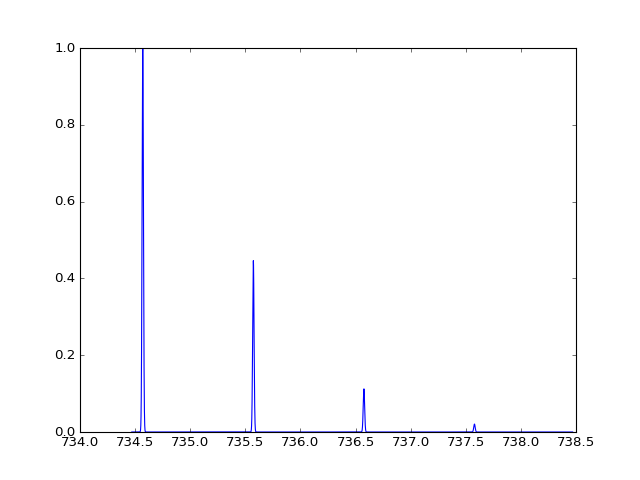

In [5]:
import numpy as np
import matplotlib.pyplot as plt

mz_min = isotopes.masses[0] - 0.1
mz_max = mz_min + 4

mzs = np.linspace(mz_min, mz_max, 100000)
intensities = isotopes.envelope(50000)(mzs)

%matplotlib notebook
plt.plot(mzs, intensities)

The visible peaks at a given resolution can be computed with `centroids()` method:

In [6]:
centroids = isotopes.centroids(50000)
print centroids

{
   734.5692: 100.0000%,
   735.5729:  44.6454%,
   736.5760:  11.2473%,
   737.5786:   2.0632%,
   738.5817:   0.2892%,
   739.5837:   0.0206%
}


Now that we have the isotopic pattern of interest, we can look at the m/z images.

First we initialize the reader object:

In [7]:
from cpyImagingMSpec import ImzbReader
imzb = ImzbReader("12hour_5_210_centroid.imzb")

The main method of `ImzbReader` class is `get_mz_image` which takes two parameters: m/z and tolerance in ppm. 

<IPython.core.display.Javascript object>


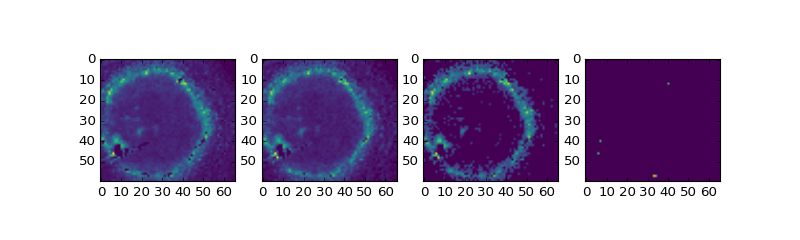

In [8]:
plt.figure(figsize=(10, 3))
images = []
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = imzb.get_mz_image(centroids.masses[i], 5)
    images.append(img)
    plt.imshow(img, cmap='viridis')

Package `cpyImagingMSpec` implements some image metrics as well:

In [9]:
from cpyImagingMSpec import measure_of_chaos, isotope_image_correlation, isotope_pattern_match
print "Measure of chaos:", measure_of_chaos(images[0], nlevels=30)
flat_images = [img.ravel() for img in images]
print "rho spatial:", isotope_image_correlation(flat_images, centroids.abundances[1:4])
print "rho spectral:", isotope_pattern_match(flat_images, centroids.abundances[:4])

Measure of chaos: 0.998768689534
rho spatial: 0.888799911671
rho spectral: 0.974481642246
